In [116]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn as nn
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

# 预处理，缩放到一定大小，然后转换为张量tensor格式。
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# 加载数据集Set12
dataset = 'D:/数据分析/数据集/Set12/'
image_files = os.listdir(dataset)

#设置的高斯标准差为0.1，噪声变动范围较小
def add_gaussian_noise(image):
    """
    添加高斯噪声
    参数:
    image : 原始图像
    """
    
    image = np.array(image).astype(float)    # 将图像转成浮点型，为了之后添加噪声
    
    # 正则化到[0,1]之间
    image /= 255
    
    # 创建一个均值为0，标准差为1/10的高斯噪声，和图像大小相同
    noise = np.random.normal(0, 0.1, image.shape)

    image_noisy = image + noise

    # 将值再限制到[0,1]之间
    image_noisy = np.clip(image_noisy, 0, 1)
    
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    image_noisy = (255*image_noisy).astype(np.uint8)
    
    # 将ndarray转换回PIL Image
    image_noisy = Image.fromarray(image_noisy)

    return image_noisy

In [ ]:
 """ 1.预处理
将输入的图像调整大小到指定的512x512尺寸，将图像转换为灰度图。
参数num_output_channels=3指的是将结果复制到三个颜色通道，因此虽然转换后的图像在视觉上是灰度的，但是它实际上仍然是一个三通道的图像。
彩色图可以删掉这一句，因为本身就是RGB格式。
将PIL Image或者NumPy ndarray格式的图像转换为torch Tensor格式，并且会归一化像素值到[0.0, 1.0]区间（原有的像素值通常在[0,255]区间）。
这样做可以方便之后的神经网络处理。
    2.加载数据集set12（灰色），VOC2012(彩色)
对比同一个去噪模型下，相同噪声下灰度图和彩色图的去噪效果
    3.加入高斯噪声（标准差为0.1、0.5、0.9）、均匀噪声（0~0.5、0.5~0.9）、白噪声（标准差为0.1、0.5、0.9）、椒盐噪声（噪声概率为0.1、0.5、0.9）、
      泊松噪声（lam=10、50、100）
对比DnCNN直接去噪和经典去噪方法+DnCNN去噪对各噪声的去噪效果
注意：要根据加入的东西对代码稍做改动
"""

In [ ]:
#椒盐噪声
def add_salt_pepper_noise(image, salt_prob=0.9, pepper_prob=0.9):
    """
    添加椒盐噪声
    参数:
    image : 原始图像
    salt_prob:盐噪声概率
    pepper_prob:椒噪声概率
    """
    # 将图像转化为浮点型并正则化到[0,1]
    img = np.array(image).astype(float) / 255
    
    # 使用numpy.random.choice随机选择需要添加噪声的像素，再分别添加盐噪声（将像素值设为1）和椒噪声（像素值为0）
    total_pixels = img.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)
    
    # 得到所有需要添加噪声的像素的位置
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
    img[coords[0], coords[1]] = 1

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
    img[coords[0], coords[1]] = 0
    
    # 将值再限制到[0,1]之间
    img = np.clip(img, 0, 1)
   
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    img_noisy = (255*img).astype(np.uint8)

    # 将ndarray转换回PIL Image并转化为RGB
    img_noisy = Image.fromarray(img_noisy).convert('RGB')

    return img_noisy


In [ ]:
#泊松噪声
def add_poisson_noise(image, lam=10):
    """
    添加泊松噪声
    参数:
    image : 原始图像
    lam: 泊松分布参数, 越大噪声越大
    """
    # 将图像转化为浮点型并正则化到[0,1]
    img = np.array(image).astype(float) / 255
    
    # 添加泊松噪声
    vals = len(np.unique(img))
    vals = 2 ** np.ceil(np.log2(vals))
    img_noisy = np.random.poisson(img * vals) / float(vals)

    # 将值再限制到[0,1]之间
    img_noisy = np.clip(img_noisy, 0, 1)
   
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    img_noisy = (255*img_noisy).astype(np.uint8)

    # 将ndarray转换回PIL Image并转化为RGB
    img_noisy = Image.fromarray(img_noisy).convert('RGB')

    return img_noisy


In [ ]:
#白噪声
def add_white_noise(image, std_dev=0.1):
    """
    添加白噪声
    参数:
    image : 原始图像
    std_dev:标准差
    """
    # 将图像转化为浮点型并正则化到[0,1]
    img = np.array(image).astype(float) / 255
    
    # 使用numpy.random.normal创建噪声，
    # 该函数的参数分别为噪声均值（在这里设置为0）、噪声的标准差以及噪声的大小（设置为图像的大小）
    noise = np.random.normal(0, std_dev, img.shape)
    img_noisy = img + noise
    
    # 将值再限制到[0,1]之间
    img_noisy = np.clip(img_noisy, 0, 1)
    
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    img_noisy = (255*img_noisy).astype(np.uint8)

    # 将ndarray转换回PIL Image
    img_noisy = Image.fromarray(img_noisy)

    return image_noisy

In [ ]:
#均匀噪声
def add_uniform_noise(image):
    """
    添加均匀噪声
    参数:
    image : 原始图像
    """
    
    image = np.array(image).astype(float)  # 将图像转成浮点型，为了之后添加噪声
    
    # 正则化到[0,1]之间
    image /= 255
    
    # 创建一个范围在[0,1/10]的均匀噪声，和图像大小相同
    noise = np.random.uniform(0.5, 0.9, image.shape)

    image_noisy = image + noise

    # 将值再限制到[0,1]之间
    image_noisy = np.clip(image_noisy, 0, 1)
    
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    image_noisy = (255*image_noisy).astype(np.uint8)
    
    # 将ndarray转换回PIL Image
    image_noisy = Image.fromarray(image_noisy)

    return image_noisy

In [ ]:
""" 4.均值滤波去噪（MF）
设置过滤器为3*3
 """

In [117]:
#均值滤波去噪
def remove_noise_with_mean_filter(image_noisy):
    """
    使用均值滤波器去噪
    参数:
    image_noisy : 有噪声的图像
    image_denoised_MF : 均值滤波(MF)去噪后的图像
    """
    # 均值滤波器的大小，可以根据实际情况进行调整
    ksize = (3, 3)
    
    # 将PIL Image转换为ndarray
    image_noisy_np = np.array(image_noisy)
    
    # 使用cv2.blur进行均值滤波
    image_denoised_np = cv2.blur(image_noisy_np, ksize)
    
    # 将ndarray转换回PIL Image
    image_denoised_MF = Image.fromarray(image_denoised_np)
    
    return image_denoised_MF

# 对图像文件进行循环，每个文件都会打开并添加噪声
for i, image_file in enumerate(image_files):
    image = Image.open(os.path.join(dataset, image_file))
    image_noisy_MF = add_gaussian_noise(image)
    image_denoised_MF = remove_noise_with_mean_filter(image_noisy_MF)
    # 保存去噪后的图像
    image_denoised_MF.save(f"D:/数据分析/数据集/Set12均波/{image_file}")

In [ ]:
 """
    5.画图对比原始图像、加入噪声的图像和MF去噪后的图像看去噪效果
"""

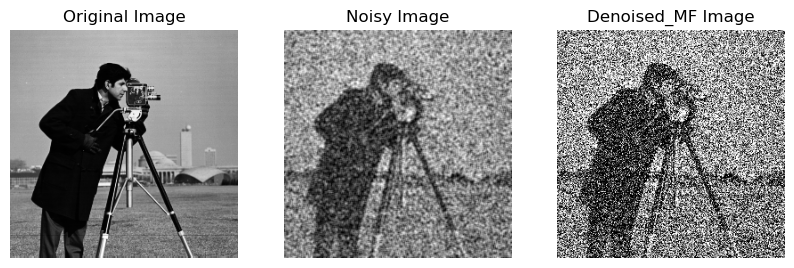

In [118]:
import matplotlib.pyplot as plt

def compare_images(image,image_noisy, image_denoised_MF):
    """
    对比原图像和均值滤波去噪后的图像
    参数:
    image ：原图像
    image_noisy : 有噪声的图像
    image_denoised_MF : 均值滤波(MF)去噪后的图像
    """
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    
    # 将图像转换为灰度图并显示
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')

    axs[1].imshow(image_noisy, cmap='gray')
    axs[1].set_title('Noisy Image')

    axs[2].imshow(image_denoised_MF, cmap='gray')
    axs[2].set_title('Denoised_MF Image')
    # 关闭坐标轴
    for ax in axs:
        ax.axis('off')

    plt.show()

# 测试一下：只显示第一张图
image_file = image_files[0]
image = Image.open(os.path.join(dataset, image_file))
compare_images(image, image_denoised_MF,image_noisy)  # 对比原图像和去噪后的图像



In [ ]:
""" 6.定义了一个DnCNN模型,网络深度为17，填充的像素数为1，卷积核尺寸3*3
CL-（CBLR）x（n-2）-C
    7.训练模型
包括前向传播、计算损失、反向传播以及优化器，然后判断是否有可用的CUDA没有就用cpu，
损失函数用均方误差MSELoss，优化器比较了几个最后用的Adam，跑25轮（epoch 0~24），
然后保存权重
"""

In [13]:
#定义DnCNN模型，训练模型，保存权重
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        running_loss = 0.0
        # 遍历数据集
        for image_file in image_files:
            image_path = os.path.join(dataset, image_file)
            image = Image.open(image_path).convert('RGB')  # 每次打开图片时，都以RGB模式打开。
            image = transform(image).unsqueeze(0)
            # 将模型参数的梯度设置为零
            optimizer.zero_grad()
            # Forward pass
            outputs = model(image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
            # 打印损失函数
            running_loss += loss.item() * image.size(0)
        epoch_loss = running_loss / len(image_files)
        print(f'Loss: {epoch_loss:.4f}')
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DnCNN(channels=3)
model = model.to(device)

criterion = nn.MSELoss()

# 优化方法Adam
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train_model(model, criterion, optimizer, num_epochs=25)

# 保存模型权重
torch.save(model.state_dict(), 'D:/数据分析/数据集/model_MF.pth')

print("Model training complete.")

Epoch 0/24
Loss: 0.2903
Epoch 1/24
Loss: 0.1094
Epoch 2/24
Loss: 0.0561
Epoch 3/24
Loss: 0.0381
Epoch 4/24
Loss: 0.0270
Epoch 5/24
Loss: 0.0215
Epoch 6/24
Loss: 0.0181
Epoch 7/24
Loss: 0.0159
Epoch 8/24
Loss: 0.0142
Epoch 9/24
Loss: 0.0130
Epoch 10/24
Loss: 0.0120
Epoch 11/24
Loss: 0.0111
Epoch 12/24
Loss: 0.0105
Epoch 13/24
Loss: 0.0099
Epoch 14/24
Loss: 0.0094
Epoch 15/24
Loss: 0.0089
Epoch 16/24
Loss: 0.0085
Epoch 17/24
Loss: 0.0082
Epoch 18/24
Loss: 0.0079
Epoch 19/24
Loss: 0.0076
Epoch 20/24
Loss: 0.0073
Epoch 21/24
Loss: 0.0071
Epoch 22/24
Loss: 0.0069
Epoch 23/24
Loss: 0.0067
Epoch 24/24
Loss: 0.0065
Model training complete.


In [ ]:
"""
    8.均值滤波去噪（MF）后再用DnCNN模型去噪,画图对比原始图像、MF去噪后的图像和MF+DnCNN去噪的图像看去噪效果
"""

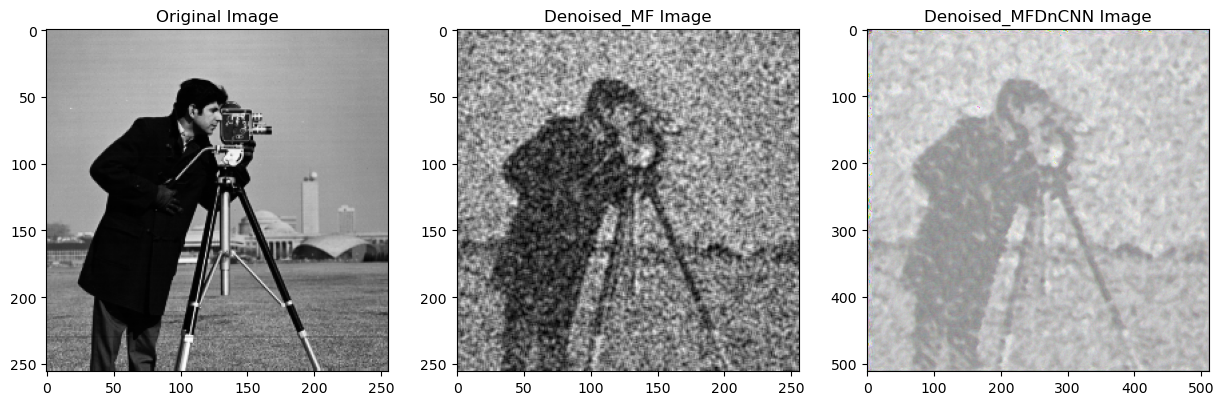

In [119]:
#高斯噪声标准差为0.1，MF去噪后再用DnCNN去噪
# 加载已经训练的DnCNN模型
dncnn_model = DnCNN(channels=3)
dncnn_model.load_state_dict(torch.load('D:/数据分析/数据集/model_MF.pth'))
dncnn_model.eval()

dataset_MF = "D:/数据分析/数据集/Set12均波/"
# 从数据集中选择一张图片
image_path = os.path.join(dataset_MF, image_files[0])
image_MF = Image.open(image_path).convert('RGB')

# 用DnCNN模型去噪
noisy_image_tensor = transform(image_denoised_MF).unsqueeze(0)
with torch.no_grad():
    denoised_image_tensor = dncnn_model(noisy_image_tensor)
    """
    使用MF+DnCNN去噪
    参数:
    image_denoised_MFDnCNN : MF去噪后用DnCNN去噪后的图像
    """
# 将denoised_image_tensor从tensor转换回图像
image_denoised_MFDnCNN = denoised_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_denoised_MFDnCNN = (image_denoised_MFDnCNN * 0.5) + 0.5    # 缩放到 [0, 1] 范围
image_denoised_MFDnCNN = (image_denoised_MFDnCNN * 255).astype(np.uint8)

# 显示原始图像、带噪声图像和去噪后的图像
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image,cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(image_MF)
plt.title('Denoised_MF Image')
plt.subplot(1, 3, 3)
plt.imshow(image_denoised_MFDnCNN,cmap='gray')
plt.title('Denoised_MFDnCNN Image')
plt.show()

In [ ]:
"""
    9.直接用DnCNN模型去噪，画图对比原始图像，加入噪声后的图像和DnCNN去噪的图像看去噪
"""

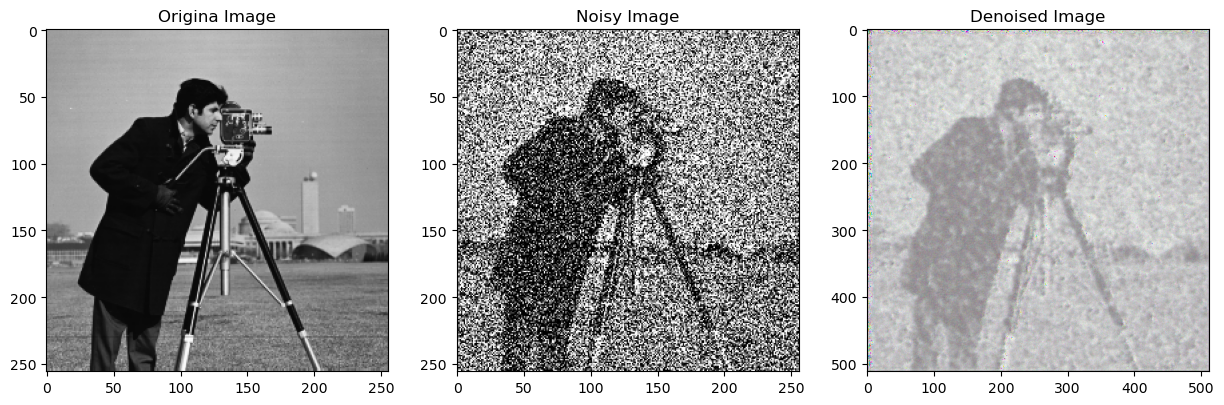

In [120]:
#高斯噪声标准差为0.1，直接用DnCNN去噪
# 加载已经训练的DnCNN模型
dncnn_model = DnCNN(channels=3)
dncnn_model.load_state_dict(torch.load('D:/数据分析/数据集/model_MF.pth'))
dncnn_model.eval()

# 从数据集中选择一张图片
image_path = os.path.join(dataset, image_files[0])
image = Image.open(image_path).convert('RGB')

# 添加高斯噪声
image_noisy_DnCNN = add_gaussian_noise(image)

# 用DnCNN模型去噪
noisy_image_tensor = transform(noisy_image).unsqueeze(0)
with torch.no_grad():
    denoised_image_tensor = dncnn_model(noisy_image_tensor)
    """
    使用DnCNN去噪
    参数:
    image_noisy_DnCNN : 有噪声的图像
    image_denoised_DnCNN : 只用DnCNN去噪后的图像
    """
# 将denoised_image_tensor从tensor转换回图像
image_denoised_DnCNN = denoised_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_denoised_DnCNN = (image_denoised_DnCNN * 0.5) + 0.5    # 缩放到 [0, 1] 范围
image_denoised_DnCNN = (image_denoised_DnCNN * 255).astype(np.uint8)

# 显示原始图像、带噪声图像和去噪后的图像
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Origina Image')
plt.subplot(1, 3, 2)
plt.imshow(image_noisy,cmap='gray')
plt.title('Noisy Image')
plt.subplot(1, 3, 3)
plt.imshow(image_denoised_DnCNN,cmap='gray')
plt.title('Denoised Image')
plt.show()

In [ ]:
"""
    10.用psnr评估去噪效果
原理PSNR = 10 * log10(MAX_I^2 / MSE），MSE = 1/(m*n) * ΣΣ[(I(i, j) - K(i, j))^2]
PSNR的值越大，代表重建的图片质量越高，去噪效果更好
"""

In [ ]:
#灰色图片psnr
from skimage.metrics import peak_signal_noise_ratio

# 先将原图像转为灰度图像
original_gray = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)

# 获取原图像的尺寸
image_shape =  original_gray.shape

# 将所有图像调整为原图像的大小
image_resized = cv2.resize(np.asarray(image), image_shape[::-1])
denoised_MFDnCNN_resized = cv2.resize(np.asarray(image_denoised_MFDnCNN), image_shape[::-1])
denoised_DnCNN_resized = cv2.resize(np.asarray(image_denoised_DnCNN), image_shape[::-1])
denoised_img_noisy_resized = cv2.resize(np.array(image_noisy_DnCNN), image_shape[1::-1])

# 再转换为灰度图像
denoised_MFDnCNN_gray = cv2.cvtColor(denoised_MFDnCNN_resized, cv2.COLOR_RGB2GRAY)
denoised_DnCNN_gray = cv2.cvtColor(denoised_DnCNN_resized, cv2.COLOR_RGB2GRAY)
denoised_img_noisy_gray = cv2.cvtColor(denoised_img_noisy_resized, cv2.COLOR_RGB2GRAY)

# 计算PSNR
psnr_MFDnCNN = peak_signal_noise_ratio(original_gray, denoised_MFDnCNN_gray)
psnr_DnCNN = peak_signal_noise_ratio(original_gray, denoised_DnCNN_gray)
psnr_img_noisy = peak_signal_noise_ratio(original_gray, denoised_img_noisy_gray)

print(f"MF+DnCNN PSNR: {psnr_MFDnCNN}")
print(f"DnCNN PSNR: {psnr_DnCNN}")
print(f"img_noisy PSNR: {psnr_img_noisy}")

In [ ]:
#彩色图片psnr
from skimage.metrics import peak_signal_noise_ratio

# 获取原图像尺寸
image_array = np.array(image)
image_shape = image_array.shape

# 将所有图像调整为原图像的大小
image_resized = cv2.resize(image_array, image_shape[1::-1])
denoised_MFDnCNN_resized = cv2.resize(np.array(image_denoised_MFDnCNN), image_shape[1::-1])
denoised_DnCNN_resized = cv2.resize(np.array(image_denoised_DnCNN), image_shape[1::-1])
denoised_img_noisy_resized = cv2.resize(np.array(image_noisy_DnCNN), image_shape[1::-1])

# 计算PSNR
psnr_MFDnCNN = peak_signal_noise_ratio(image_resized, denoised_MFDnCNN_resized)
psnr_DnCNN = peak_signal_noise_ratio(image_resized, denoised_DnCNN_resized)
psnr_img_noisy = peak_signal_noise_ratio(image_resized, denoised_img_noisy_resized)

print(f"MF+DnCNN PSNR: {psnr_MFDnCNN}")
print(f"DnCNN PSNR: {psnr_DnCNN}")
print(f"image_noisy PSNR: {psnr_img_noisy}")


In [ ]:
 # 获取原图像的大小和颜色通道数
image_shape = np.array(image).shape

# 转换单通道灰度图像为多通道
if len(image_shape) == 2:
    image_shape = image_shape + (3,)

# 调整图像尺寸
image = cv2.resize(np.array(image), (image_shape[1], image_shape[0]))
image_denoised_MF = cv2.resize(np.array(image_denoised_MF), (image_shape[1], image_shape[0]))

# 如果原图像为灰度图像，将去噪图像也转为灰度图像
if len(np.array(image).shape) == 2:
    image_denoised_MF = cv2.cvtColor(image_denoised_MF, cv2.COLOR_RGB2GRAY)

# 计算PSNR
psnr_MF = peak_signal_noise_ratio(image, image_denoised_MF)

print(f"MF PSNR: {psnr_MF}")

In [ ]:
#中值滤波去噪
def remove_noise_with_median_filter(image_noisy):
    """
    使用中值滤波器去噪
    参数:
    image_noisy : 有噪声的图像
    """
    # 中值滤波器的大小，可以根据实际情况进行调整
    ksize = 3
    
    # 将PIL Image转换为ndarray
    image_noisy_np = np.array(image_noisy)
    
    # 使用cv2.medianBlur进行中值滤波
    image_denoised_np = cv2.medianBlur(image_noisy_np, ksize)
    
    # 将ndarray转换回PIL Image
    image_denoised_MF = Image.fromarray(image_denoised_np)
    
    return image_denoised_MF

image_denoised_MF = remove_noise_with_median_filter(image_noisy_MF)

In [ ]:
#小波转换去噪
import pywt

def wavelet_denoising(img, wavelet='db1', level=1):
    """
    使用小波变换进行去噪
    参数:
    img : 有噪声的图像
    wavelet: 所用小波基，默认'db1'(Daubechies小波),其他还有'haar', 'sym2'等
    level: 分解层数，默认为1
    """
    # 转为灰度图并正则化到[0,1]
    img = np.array(img.convert('L')).astype(float) / 255
    # 使用小波变换进行去噪
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)

    # 对高频部分进行阈值处理
    threshold = 0.02
    for i in range(1, len(coeffs)):
        coeffs[i] = tuple(pywt.threshold(detail, threshold * np.max(detail), mode="hard") 
                          for detail in coeffs[i])

    # 利用阈值处理后的小波系数重构图像
    img_denoised = pywt.waverec2(coeffs, wavelet)

    # 转换回uint8类型并返回
    return Image.fromarray((img_denoised*255).astype(np.uint8))

for i, image_file in enumerate(image_files):
    image = Image.open(os.path.join(dataset, image_file))
    image_noisy = add_poisson_noise(image)
    image_denoised = wavelet_denoising(image_noisy)
    # 保存去噪后的图像
    image_denoised.save(f"D:/数据分析/数据集/练习/{image_file}_{i}.png")
    

In [ ]:
#小波去噪彩色版本
import pywt

def wavelet_denoising(image_noisy, wavelet='db1', level=1):
    """
    利用小波去噪
    参数:
    image: 含噪图像
    wavelet: 所使用的小波类型, 默认'db1'，即Daubechies小波系列，其它还有‘haar’, 'sym2'等
    level: 分解的层数，默认为1
    """
    # 转为灰度图，进行归一化处理
    img = np.array(image_noisy.convert('L')).astype(float) / 255
    # 利用小波进行去噪
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    
    # 高频部分进行阈值处理
    threshold = 0.02
    for i in range(1, len(coeffs)):
        coeffs[i] = tuple(pywt.threshold(coef, threshold * np.max(coef), mode='hard') for coef in coeffs[i])
        
    # 利用阈值后的小波分量重构图像
    img_denoised = pywt.waverec2(coeffs, wavelet=wavelet)
    
    # 转回uint8类型并返回
    return Image.fromarray((img_denoised * 255).astype(np.uint8))

for i, image_file in enumerate(image_files):
    image = Image.open(os.path.join(dataset, image_file))
    image_noisy = add_salt_pepper_noise(image)
    # 将噪声图像转为RGB
    image_noisy_rgb = image_noisy.convert('RGB')
    # 小波去噪
    # 将图像处理为RGB通道，每个通道独立处理
    channels = cv2.split(np.array(image_noisy_rgb))
    channels_denoised = [wavelet_denoising(Image.fromarray(channel, 'L')) for channel in channels]
    # 合并三个通道
    image_denoised_MF = Image.merge('RGB', channels_denoised)

    # 保存去噪后的图像
    image_denoised_MF.save(f"D:/数据分析/数据集/练习/{image_file}_{i}.png")

